# Tutorial #3 :: The Particle Filter
Particle filters are incredibly simple yet powerful estimation techniques. The idea is this: we're trying to estimate some variable, and all we have are observations that some sensor has made about that variable, or a function thereof. Each observation made by these sensors makes a given estimate of the variable more or less *likely*. 

Particle filters are essentially maximum likelihood estimators (MLE) or Bayesian Likelihood estimators. Here are the steps for a particle filter:

1.  We define a number of particles, N, with a given distribution about some variable space--e.g. a 2D plane if we're trying to estimate a 2D position. Each particle represents a guess of the variable's value.
2.  We gather some observations about that variable, like ranges.
3.  We calculate the likelihood L of each particle given these observations.
4.  We normalize all likelihoods so that they sum up to 1 across all N particles, giving a valid probability density function (PDF).
5.  We use the particles to calculate an estimate--usually just taking the arithmetic mean, but sometimes finding the largest *cluster* and finding the centroid of that single cluster.
6. We treat the normalized likelihoods as a PDF, resampling all N particles based on the new distribution. 
7.  We add a bit of noise to these estimates to allow for *exploration* of new estimtes--this is called innovation noise.
8.  We repeat steps 2 through 7.

Easy, right? Let's demonstrate how this might work. We *could* use the inertial data from Tutorials [1] and [2], but let's do something new. Let's simulate an object walking around in a perfect circle on a 2D grid. Around this grid we'll have a number of sensors, or *anchor* nodes that can calculate a range to the node.  These anchor nodes will never calculate ranges at the same time, however, so we can't just solve a trilateration or least squares problem.

Let's use a particle filter! First, let's set up the simulation.

In [1]:
import numpy as np

# environment
BOUNDX = [-5,5]
BOUNDY = [-5,5]
# Path shape and speed
PATHRAD = 3.5
PATHVEL = 1.0
# anchors
ANCRAD = 4.5
NUMANC = 4
# timing
TSTOP = 60
TSTEP = (1.0/10)

# true path
times = np.arange(TSTOP, step=TSTEP)
path_angle = times*(PATHVEL/PATHRAD)
path_x = np.cos(path_angle)*PATHRAD
path_y = np.sin(path_angle)*PATHRAD
path_xy = np.stack([path_x,path_y], axis=1)

# anchor positions
anc_angles = [i*(2*np.pi)/NUMANC for i in range(NUMANC)]
anc_x = [ANCRAD*np.cos(angle)for angle in anc_angles]
anc_y = [ANCRAD*np.sin(angle)for angle in anc_angles]
anc_xy = np.stack([anc_x,anc_y], axis=1)

Let's plot this path just so we can see what it'll look like, though it's just a perfect circle when viewed all at once.

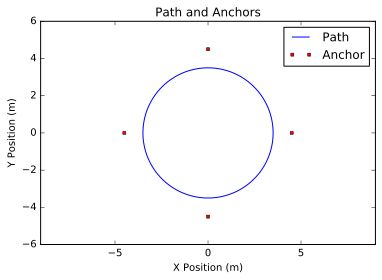

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Plot path
plt.plot(path_xy[:,0], path_xy[:,1], 'b', markersize=3)  
# Plot anchors
plt.plot(anc_xy[:,0], anc_xy[:,1], 'rs', markersize=3)

plt.title('Path and Anchors')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.legend(['Path', 'Anchor'])
plt.show()

Let's go ahead and jump into our particle filter demonstration. We'll be looping through time indices, and at each time index *one* of the anchor nodes *might* make a range estimate, but there may also be no new measurement available in which case the innovation noise will diverge our particles to ensure we don't get stuck in a local minimum.

We'll also be sure to add some noise to the range measurements themselves--Gaussian, in this case.

KeyboardInterrupt: 

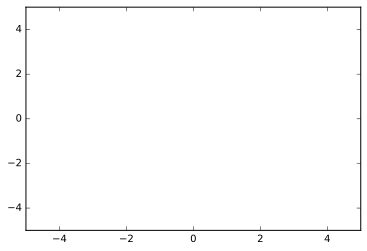

In [7]:
import scipy
import time
from IPython import display

# Particle variables
N = 100
part_x = [scipy.rand()*(BOUNDX[1]-BOUNDX[0]) + BOUNDX[0] for x in range(N)]
part_y = [scipy.rand()*(BOUNDY[1]-BOUNDY[0]) + BOUNDY[0] for x in range(N)]
part_xy = np.stack([part_x,part_y], axis=1)
innovation = 0.20

# Range measurement variables
range_noise = 0.1*1.0
range_prob = 0.25

# Run the particle filter simulation
for idx in range(len(times)):
    t = times[idx]
    tru_xy = path_xy[idx,:]
    
    # Add innovation noise to our particles
    for pidx in range(len(part_xy)):
        part_xy[pidx] += [scipy.randn()*innovation, scipy.randn()*innovation]
    
    # with some probability, we have a single range measurement
    anc_idx = -1
    if scipy.rand() < range_prob:
        # pick a random anchor
        anc_idx = np.random.randint(NUMANC)
        axy = anc_xy[anc_idx,:]
        
        # calculate noisy range
        range_est = np.linalg.norm([tru_xy - axy]) + scipy.randn()*range_noise
        
        # calculate likelihood of all particles -- here we assume range noise is Gaussian, but it could be anything.
        L = []
        for pidx in range(len(part_xy)):
            pxy = part_xy[pidx,:]
            range_part = np.linalg.norm([pxy-axy])
            l = (1.0/(range_noise*np.sqrt(2.0*np.pi)))*np.exp((-(range_est-range_part)**2)/(2.0*range_noise**2))
            L.append(l)
            
        # normalize all likelihoods
        L /= np.sum(L)
        
        # resample particles based on normalized PDF
        new_particle_idxs = np.random.choice(range(N), N, True, p=L)
        part_xy = part_xy[new_particle_idxs]
        
    # get new position estimate via particle centroid
    est_xy = np.mean(part_xy,0)
    
    # update our plot
    plt.clf()
    plt.plot(anc_xy[:,0], anc_xy[:,1], 'rs', markersize=3)
    plt.plot(est_xy[0], est_xy[1], 'bo', markersize=7)
    plt.plot(tru_xy[0], tru_xy[1], 'g^', markersize=7)
    plt.plot(part_xy[:,0], part_xy[:,1], 'ko', markersize=1)
    if anc_idx >= 0:
        plt.plot(anc_xy[anc_idx,0], anc_xy[anc_idx,1], 'gs', markersize=10)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.xlim(BOUNDX)
    plt.ylim(BOUNDY)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # pause for visualization
    time.sleep(TSTEP)


And that's it! If we have more than one observation for a given particle at a single iteration, we can just combine the likelihoods (multiply if they're independent observations) before normalization. And of course it's quite easy to extend this to any other observation beyond ranges.